In [1]:
! pip install pandas openpyxl sentence-transformers scikit-learn matplotlib seaborn

In [8]:
import os
import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt  # KoNLPy의 Okt 형태소 분석기 사용

# 1. 환경 설정 및 모델 로드
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

okt = Okt() # 형태소 분석기 객체 생성
model = SentenceTransformer('intfloat/multilingual-e5-small')
root_path = r'G:\내 드라이브\빅데이터_부산\텍스트(네이버 리뷰)'

# 2. 강화된 불용어 사전 (명사 추출 후 제거되므로 명사 위주로 구성)
stopwords = [
    '부산', '부산시', '부산여행', '부산가볼만한곳', '경남', '부산역',
    '여행', '사진', '모습', '생각', '오늘', '이번', '추천', '인기', '방문', 
    '정보', '위치', '문화', '관련', '보고', '정말', '준비', '시작', '함께',
    '이용', '내용', '상황', '확인', '진짜', '너무', '정말', '최고', '소개',
    '관리', '하나', '곳곳', '정도', '이후', '다른', '다양한', '사람', '주말'
]

def extract_nouns(text):
    if pd.isna(text): return ""
    # 1. 한글 외 제거
    text = re.sub(r'[^가-힣\s]', ' ', str(text))
    # 2. Okt를 이용한 명사 추출 (2글자 이상만)
    nouns = okt.nouns(text)
    nouns = [n for n in nouns if n not in stopwords and len(n) > 1]
    return " ".join(nouns)

# 3. 데이터 로드 및 형태소 분석 (시간이 다소 소요될 수 있습니다)
place_raw_data = []
all_docs = []

print("형태소 분석 및 데이터 로드 시작...")

for addr, dirs, files in os.walk(root_path):
    for file_name in files:
        if file_name.endswith(('.csv', '.xlsx')):
            file_path = os.path.join(addr, file_name)
            district_name = os.path.basename(addr)
            place_name = f"{district_name}_{os.path.splitext(file_name)[0]}"
            
            try:
                df = pd.read_csv(file_path) if file_name.endswith('.csv') else pd.read_excel(file_path)
                if '제목' not in df.columns or '본문' not in df.columns: continue
                
                # 제목 가중치 + 본문 결합
                full_raw_text = (df['제목'].fillna('') + " ") * 2 + df['본문'].fillna('')
                # 모든 리뷰를 합쳐서 한 번에 명사 추출
                combined_text = " ".join(full_raw_text.tolist())
                processed_nouns = extract_nouns(combined_text)
                
                if len(processed_nouns) > 50:
                    place_raw_data.append({'name': place_name, 'text': processed_nouns})
                    all_docs.append(processed_nouns)
                    print(f"  - [형태소 분석 완료] {place_name}")
            except Exception as e:
                print(f"  - [오류] {place_name}: {e}")

# 4. TF-IDF를 통한 핵심 키워드 재구성
tfidf = TfidfVectorizer(max_features=1500)
tfidf_matrix = tfidf.fit_transform(all_docs)
feature_names = tfidf.get_feature_names_out()

place_names = []
place_vectors = []

print("\n고정밀 임베딩 생성 중...")

for i, data in enumerate(place_raw_data):
    # TF-IDF 기반 상위 40개 핵심 명사 추출
    row = tfidf_matrix.getrow(i).toarray()[0]
    top_indices = row.argsort()[-40:][::-1]
    core_keywords = " ".join([feature_names[idx] for idx in top_indices if row[idx] > 0])
    
    # 모델 입력: passage 접두사 + 핵심 명사 리스트
    # (본문 전체 대신 핵심어 위주로 구성하여 변별력 극대화)
    input_text = f"passage: {core_keywords}"
    
    with torch.no_grad():
        vector = model.encode(input_text, convert_to_tensor=True)
        place_names.append(data['name'])
        place_vectors.append(vector)

# 5. 유사도 계산 및 정규화
all_embeddings = torch.stack(place_vectors)
sim_matrix = util.cos_sim(all_embeddings, all_embeddings).cpu().numpy()

# 시각화를 위한 Min-Max Scaling
sim_min, sim_max = sim_matrix.min(), sim_matrix.max()
norm_sim_matrix = (sim_matrix - sim_min) / (sim_max - sim_min)

# 6. 클러스터맵 시각화
plt.figure(figsize=(22, 20))
sns.clustermap(norm_sim_matrix, cmap='YlGnBu', 
               xticklabels=place_names, yticklabels=place_names,
               dendrogram_ratio=0.1)
plt.title('부산 관광지 형태소 기반 유사도 분석 (Okt + KoE5)')
plt.savefig('busan_similarity_konlpy.png', dpi=300)

print("\n" + "="*60)
print("형태소 분석 기반 타 지역구 유사 명소 TOP 3")
print("="*60)

for i, name in enumerate(place_names):
    scores = sim_matrix[i]
    sorted_idx = np.argsort(scores)[::-1]
    current_district = name.split('_')[0]
    count = 0
    print(f"\n[{name}]")
    for idx in sorted_idx:
        target_name = place_names[idx]
        if name != target_name and current_district != target_name.split('_')[0]:
            print(f"  - {target_name} ({scores[idx]:.4f})")
            count += 1
            if count >= 3: break

JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

총 73개의 관광지 데이터를 로드했습니다.
임베딩 생성 중...
분석 결과 저장 완료 (CSV)
변별력이 강화된 시각화 생성 중...


<Figure size 2000x1800 with 0 Axes>

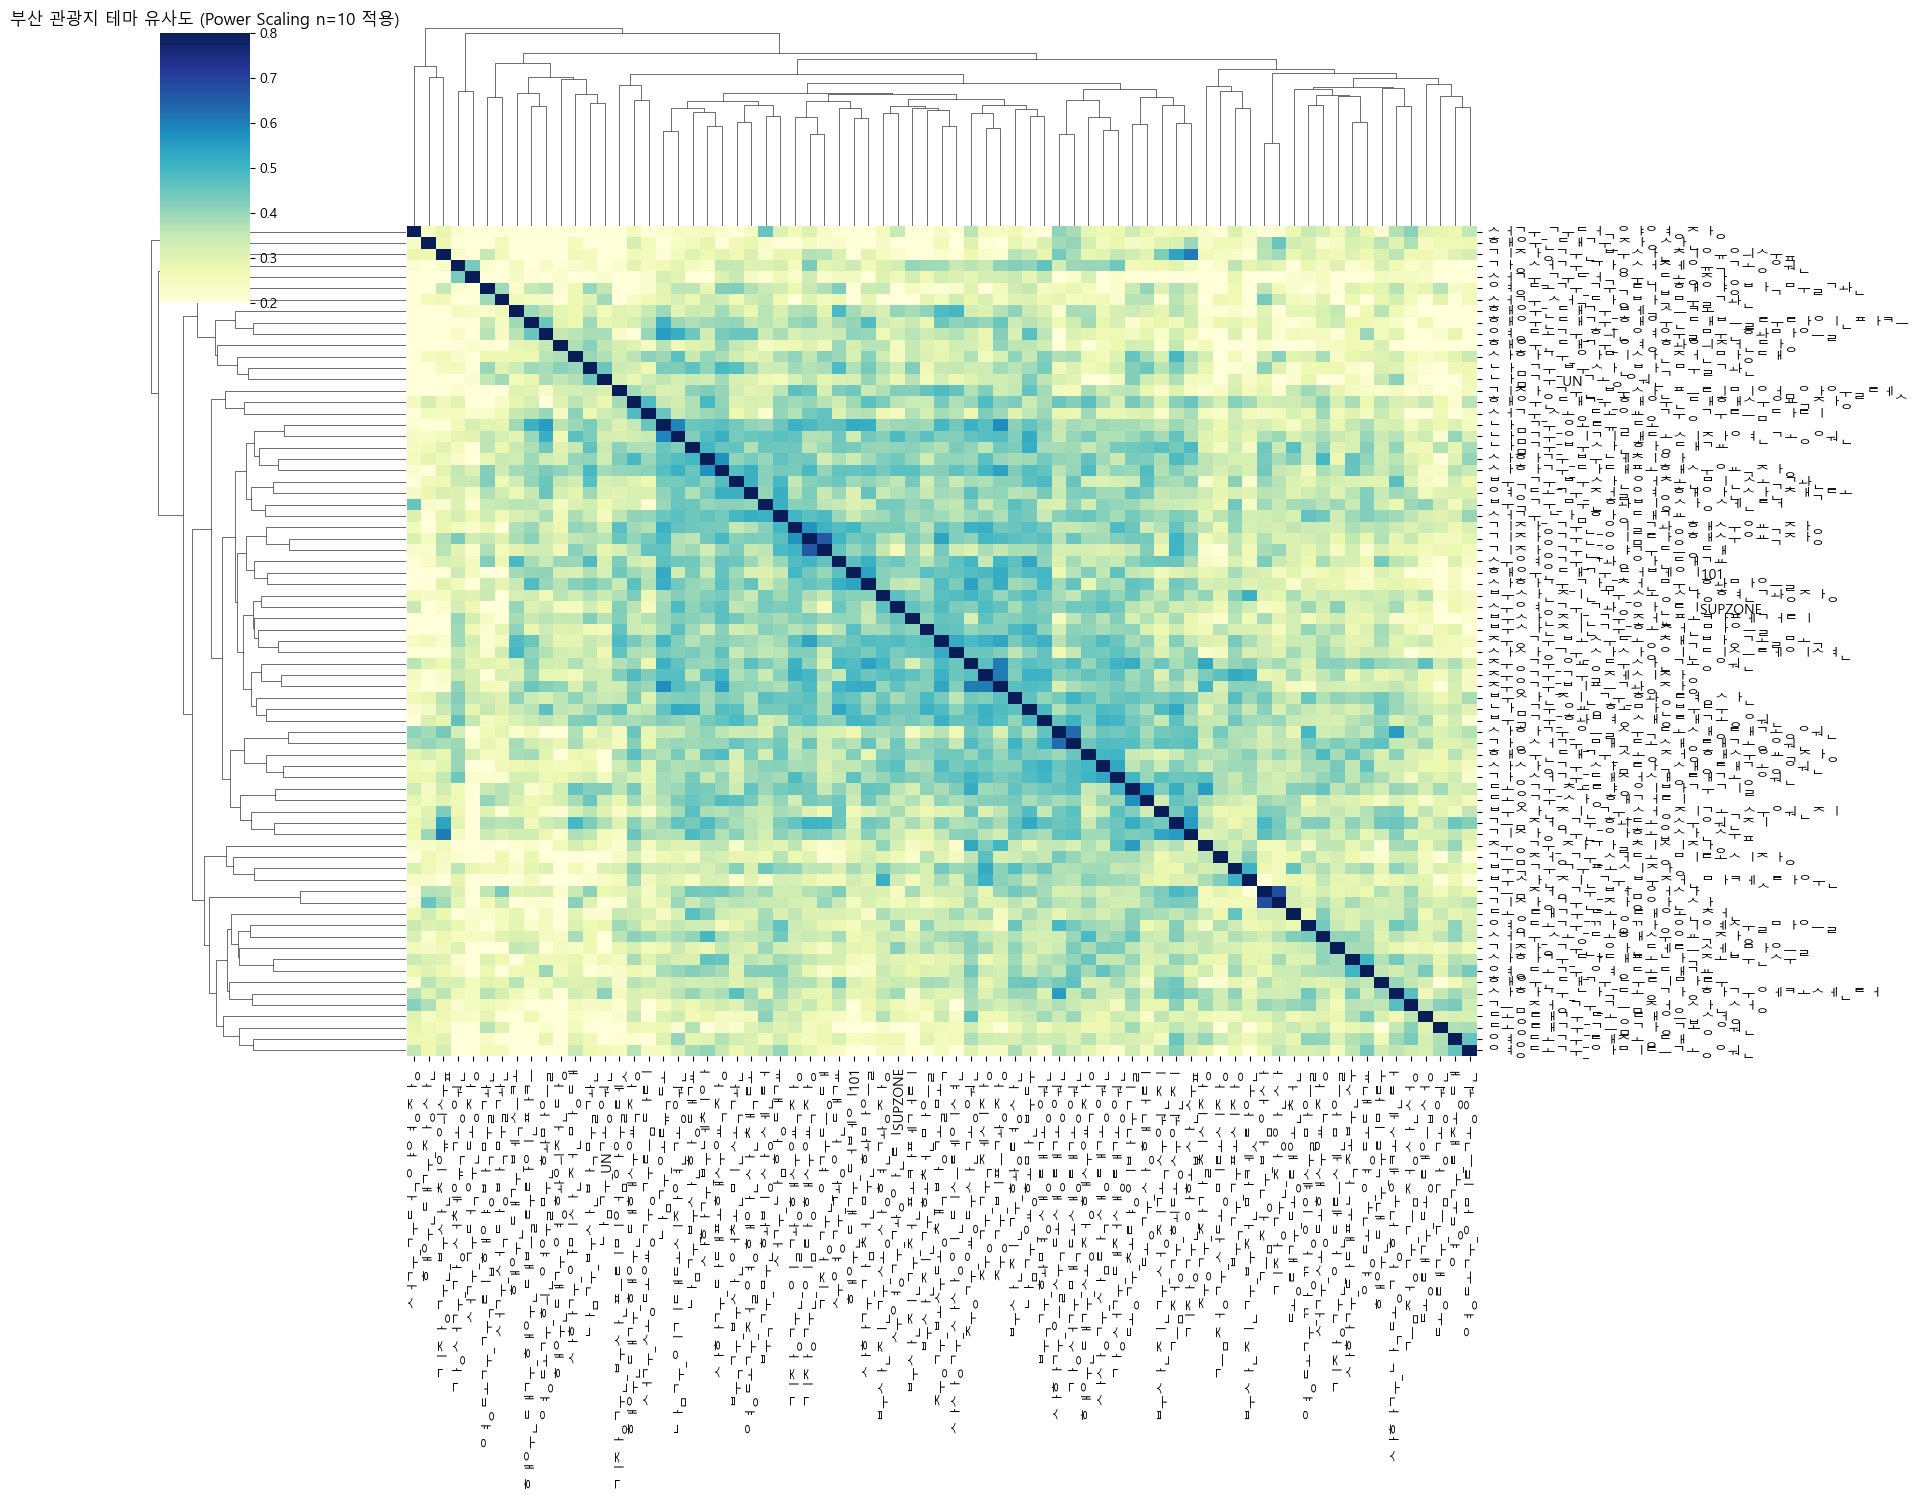

In [4]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# 1. 환경 설정
# 로컬에서 한글 깨짐 방지 (Windows 기준: Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 전처리 데이터 로드 (파일이 같은 폴더에 있어야 함)
csv_path = 'busan_preprocessed_nouns.csv'
if not os.path.exists(csv_path):
    print(f"Error: {csv_path} 파일이 없습니다. Step 1 결과물을 먼저 준비하세요.")
    exit()

df_pre = pd.read_csv(csv_path)
place_names = df_pre['place_name'].tolist()
all_docs = df_pre['nouns_content'].fillna('').tolist()

print(f"총 {len(place_names)}개의 관광지 데이터를 로드했습니다.")

# 2. 모델 로드 (최초 실행 시 모델 다운로드 진행됨)
model = SentenceTransformer('intfloat/multilingual-e5-small')

# 3. TF-IDF 변별력 강화
# max_df: 0.3 (30% 이상 공통 단어 제외)
tfidf = TfidfVectorizer(max_df=0.1, min_df=2, max_features=1000)
tfidf_matrix = tfidf.fit_transform(all_docs)
feature_names = tfidf.get_feature_names_out()

place_vectors = []
print("임베딩 생성 중...")
for i in range(len(all_docs)):
    row = tfidf_matrix.getrow(i).toarray()[0]
    top_indices = row.argsort()[-25:][::-1] 
    core_keywords = " ".join([feature_names[idx] for idx in top_indices if row[idx] > 0])
    
    with torch.no_grad():
        # 고유 키워드만 사용하여 장소 간 거리를 벌림
        vector = model.encode(f"passage: {core_keywords}", convert_to_tensor=True)
        place_vectors.append(vector)

# [수정된 4번 섹션] 유사도 계산 및 수치 확장
all_embeddings = torch.stack(place_vectors)
sim_matrix = util.cos_sim(all_embeddings, all_embeddings).cpu().numpy()

# 1. 지수 스케일링 (Power Scaling): 차이를 시각적으로 극대화
# n 값이 클수록 점수 차이가 더 드라마틱하게 벌어집니다. (5~10 추천)
n = 10
expanded_sim = np.power(sim_matrix, n)

# 수치가 밀집되는 현상을 해결하기 위해 0~1로 스케일링 (시각화/분석용)
sim_min, sim_max = sim_matrix.min(), sim_matrix.max()
norm_sim_matrix = (sim_matrix - sim_min) / (sim_max - sim_min)

# 5. 결과 저장 (CSV)
# 전체 매트릭스 저장
pd.DataFrame(sim_matrix, index=place_names, columns=place_names).to_csv('busan_final_similarity.csv', encoding='utf-8-sig')

# 추천 리스트 저장 (타 지역구 기반)
recommend_list = []
for i, name in enumerate(place_names):
    scores = sim_matrix[i]
    sorted_idx = np.argsort(scores)[::-1]
    current_dist = name.split('_')[0]
    
    rank = 1
    for idx in sorted_idx:
        target_name = place_names[idx]
        if name != target_name and current_dist != target_name.split('_')[0]:
            recommend_list.append({
                '기준': name, '추천': target_name, '유사도': scores[idx], '순위': rank
            })
            rank += 1
            if rank > 3: break

pd.DataFrame(recommend_list).to_csv('busan_recommend_list.csv', index=False, encoding='utf-8-sig')
print("분석 결과 저장 완료 (CSV)")

# 6. 시각화 (Clustermap 사용 - 유사 그룹끼리 자동 묶음)
print("변별력이 강화된 시각화 생성 중...")
plt.figure(figsize=(20, 18))
# vmin, vmax를 설정하여 색상 대비를 더 강하게 줍니다.
sns.clustermap(norm_sim_matrix, xticklabels=place_names, yticklabels=place_names, 
               cmap='YlGnBu', figsize=(18, 15), vmin=0.2, vmax=0.8)
plt.title(f'부산 관광지 테마 유사도 (Power Scaling n={n} 적용)')
plt.savefig('busan_enhanced_contrast_map.png', dpi=300)
plt.show()

In [6]:
! pip install rank_bm25


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler

# 1. 환경 설정 및 데이터 로드
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_pre = pd.read_csv('busan_preprocessed_nouns.csv')
place_names = df_pre['place_name'].tolist()
corpus = df_pre['nouns_content'].fillna('').tolist()
tokenized_corpus = [doc.split() for doc in corpus]

# 2. BM25 점수 계산
print("1/3: BM25 점수 계산 중...")
bm25 = BM25Okapi(tokenized_corpus)
bm25_matrix = np.zeros((len(place_names), len(place_names)))
for i, tokens in enumerate(tokenized_corpus):
    bm25_matrix[i] = bm25.get_scores(tokens)

# 3. E5 임베딩 점수 계산
print("2/3: E5 임베딩 점수 계산 중...")
model = SentenceTransformer('intfloat/multilingual-e5-small')
with torch.no_grad():
    # passage: 접두사를 붙여 핵심 키워드 임베딩
    embeddings = model.encode([f"passage: {doc}" for doc in corpus], convert_to_tensor=True)
    e5_sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

# 4. 점수 정규화 및 앙상블 (5:5)
print("3/3: 점수 병합(Ensemble) 및 정규화 중...")
scaler = MinMaxScaler()

# BM25 정규화 (점수 범위가 크므로 0~1로 변환)
norm_bm25 = scaler.fit_transform(bm25_matrix)
norm_bm25 = (norm_bm25 + norm_bm25.T) / 2 # 대칭화

# E5 정규화 (0.8~0.9에 몰린 점수를 0~1로 확장)
norm_e5 = scaler.fit_transform(e5_sim_matrix)

# 최종 결합 (5:5 가중치)
final_sim_matrix = (norm_bm25 * 0.5) + (norm_e5 * 0.5)

# 5. 결과 저장 및 시각화
sim_df = pd.DataFrame(final_sim_matrix, index=place_names, columns=place_names)
sim_df.to_csv('busan_ensemble_similarity.csv', encoding='utf-8-sig')

place_names = sim_df.index.tolist()
sim_matrix = sim_df.values

recommend_data = []

print("유사도 순위 리스트 생성 중...")

for i, base_place in enumerate(place_names):
    # 해당 관광지의 유사도 점수 추출
    scores = sim_matrix[i]
    
    # 점수 내림차순 정렬 인덱스 추출
    sorted_indices = np.argsort(scores)[::-1]
    
    rank = 0 # 자기 자신을 제외하기 위한 카운트
    for idx in sorted_indices:
        target_place = place_names[idx]
        
        # 1. 자기 자신 제외 (유사도 1.0인 경우)
        if base_place == target_place:
            continue
            
        rank += 1
        recommend_data.append({
            '기준_관광지': base_place,
            '유사_관광지': target_place,
            '유사도_수치': round(float(scores[idx]), 4),
            '순위': rank
        })
        
        # 상위 10개만 저장하고 싶다면 아래 주석 해제 (전체 저장을 원하면 그대로 유지)
        # if rank >= 10: break

# 2. DataFrame 변환 및 저장
final_list_df = pd.DataFrame(recommend_data)

# CSV 저장 (엑셀 한글 깨짐 방지를 위해 utf-8-sig 사용)
output_filename = 'busan_similarity_ranking.csv'
final_list_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n[저장 완료] '{output_filename}' 파일이 생성되었습니다.")
print(final_list_df.head(15)) # 상위 결과 일부 출력


1/3: BM25 점수 계산 중...
2/3: E5 임베딩 점수 계산 중...
3/3: 점수 병합(Ensemble) 및 정규화 중...
유사도 순위 리스트 생성 중...

[저장 완료] 'busan_similarity_ranking.csv' 파일이 생성되었습니다.
                  기준_관광지                         유사_관광지  유사도_수치  순위
0   남구_부산박물관           서구_석당박물관  0.5458   1
1   남구_부산박물관            동래구_동래읍성  0.4181   2
2   남구_부산박물관             서구_구덕야영장  0.3777   3
3   남구_부산박물관   영도구_국립해양박물관  0.3640   4
4   남구_부산박물관              영도구_영도대교  0.3300   5
5   남구_부산박물관         사하구_아미산전망대  0.3271   6
6   남구_부산박물관      북구_부산어촌민속관  0.3079   7
7   남구_부산박물관     영도구_깡깡이예술마을  0.3054   8
8   남구_부산박물관  사하구_낙동강하구에코센터  0.2949   9
9   남구_부산박물관     영도구_흰여울문화마을  0.2932  10
10  남구_부산박물관                북구_구포시장  0.2926  11
11  남구_부산박물관            

In [10]:
import pandas as pd
import numpy as np

# 1. 기존 유사도 매트릭스 로드 (이전 단계에서 계산된 sim_df 활용)
# sim_df = pd.read_csv('busan_ensemble_similarity.csv', index_col=0)

place_names = sim_df.index.tolist()
sim_matrix = sim_df.values

# 추출할 유사 관광지 개수 설정 (예: 상위 5개)
top_n = 72

final_rows = []

print(f"관광지별 상위 {top_n}개 유사 명소 추출 중...")

for i, base_place in enumerate(place_names):
    # 해당 관광지의 유사도 점수 추출
    scores = sim_matrix[i]
    
    # 내림차순 정렬 후 자기 자신(첫 번째)을 제외한 인덱스 추출
    sorted_indices = np.argsort(scores)[::-1]
    top_indices = [idx for idx in sorted_indices if place_names[idx] != base_place][:top_n]
    
    # 기본 정보 설정
    row_dict = {'기준_관광지': base_place}
    
    # 유사 관광지와 점수를 한 셀에 합쳐서 열 추가
    for rank, idx in enumerate(top_indices, 1):
        target_name = place_names[idx]
        score = round(float(scores[idx]), 4)
        
        # '관광지명(점수)' 형식으로 데이터 생성
        row_dict[f'유사_관광지_{rank}'] = f"{target_name}({score})"
    
    final_rows.append(row_dict)

# 2. DataFrame 변환 및 저장
wide_format_df = pd.DataFrame(final_rows)

# CSV 저장 (엑셀 최적화)
output_filename = 'busan_recommendation_wide.csv'
wide_format_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n[저장 완료] '{output_filename}' 파일이 생성되었습니다.")
# 결과 확인
print(wide_format_df.head())

관광지별 상위 72개 유사 명소 추출 중...

[저장 완료] 'busan_recommendation_wide.csv' 파일이 생성되었습니다.
                        기준_관광지                      유사_관광지_1  \
0         남구_부산박물관  서구_석당박물관(0.5458)   
1           남구_용호만부두   해운대구_더베이101(0.4613)   
2           남구_부산항대교  서구_석당박물관(0.3411)   
3                남구_오륙도  서구_석당박물관(0.4507)   
4  남구_이기대도시자연공원    서구_구덕야영장(0.4297)   

                                 유사_관광지_2  \
0             동래구_동래읍성(0.4181)   
1  해운대구_해운대블루라인파크(0.379)   
2          사하구_아미산전망대(0.3188)   
3              서구_구덕야영장(0.4232)   
4           사하구_아미산전망대(0.425)   

                                  유사_관광지_3  \
0               서구_구덕야영장(0.3777)   
1           사하구_아미산전망대(0.3633)   
2       해운대구_송정해수욕장(0.3164)   
3  해운대구_해운대블루라인파크(0.4228)   
4             서구_석당박물관